## Predicting ED Disposition from EMS Reports  
### Business Understanding

![Naloxone (Narcan) - Opioid Overdose Rescue Drug](../src/images/narcan.jpg)

> **Image Credit**: Naloxone (Narcan) image sourced from [Harvard Health Publishing – Should you carry the opioid overdose rescue drug naloxone?](https://www.health.harvard.edu/blog/should-you-carry-the-opioid-overdose-rescue-drug-naloxone-2018050413773)


Every day, EMS providers respond to thousands of 911 calls across the U.S., treating patients in the field and transporting them to emergency departments (EDs). However, not all patients require hospital admission. Some are treated and discharged, while others are admitted, transferred, or, in rare cases, die shortly after arrival.

The ability to predict ED disposition using only prehospital data could help EMS agencies, hospitals, and public health teams:

- Improve resource planning (e.g., bed availability, staffing)
- Identify high-risk patients earlier
- Support training and protocol development
- Enhance communication between EMS and hospitals

This project seeks to build a supervised machine learning model that predicts whether a patient transported by EMS will ultimately be **admitted, transferred, or die** (vs. being **discharged or leaving against medical advice**) based solely on the EMS report data.

**Key Business Question:**  
Can we predict ED disposition using only information documented by EMS before hospital arrival?

**Target Stakeholders:**  
- EMS medical directors and operations managers  
- Hospital emergency department administrators  
- Public health analysts and policymakers

In [468]:
# --- Core Libraries ---
import numpy as np
import pandas as pd
import re

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_importance

# --- Modeling ---
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# --- Preprocessing ---
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import (
    LabelEncoder,
    MultiLabelBinarizer,
    OneHotEncoder,
    StandardScaler
)

# --- Evaluation ---
from sklearn.metrics import (
    auc,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    make_scorer,
    precision_recall_curve,
    recall_score,
    roc_auc_score,
    roc_curve
)

# --- Explainability ---
import shap

## Data Understanding

The dataset for this project is derived from the National Emergency Medical Services Information System (NEMSIS) 2023 Research Dataset, which contains over 54 million EMS activations nationwide. Our working dataset was constructed by filtering for records that contain valid hospital outcome data, reducing the size to 5,677 EMS events with 99 features.

### Dataset Overview

- **Initial Size**: 297,762 rows × 98 columns  
- **Final Subset**: 5,677 rows × 99 columns  
- **Target Variable**: `eOutcome_01`, which describes the patient’s emergency department (ED) disposition  
- **Class Balance (after grouping into binary labels)**:
  - `1` (Admitted, Transferred, or Deceased): ~53.4%
  - `0` (Discharged or Left AMA): ~46.6%

### Outcome Distribution (Uncollapsed)

| Outcome | Count |
|--------|-------|
| Discharged to home or self care | 2240 |
| Still a patient / outpatient return | 1450 |
| Admitted as inpatient | 955 |
| Left against medical advice (AMA) | 315 |
| Transferred (various destinations) | ~500 |
| Deceased / Expired | 46 |
| Others (SNF, rehab, etc.) | <100 each |

These categories were grouped into two classes for modeling:
- Class `1`: Patients admitted, transferred to another facility, or deceased
- Class `0`: Patients discharged or who left against medical advice (AMA)

### Feature Types

The dataset includes a variety of feature types:
- **Categorical features**: e.g., dispatch reasons, arrest details, protocol codes
- **Numeric features**: protocol count, vital signs (e.g., heart rate, BP), race count
- **Engineered flags**: Boolean indicators for witnessed arrests, CPR provided, ROSC, etc.

### Missing Data

Several key clinical fields had significant missingness:

| Feature         | Missing Fraction |
|----------------|------------------|
| ETCO2          | 78.3%            |
| Blood Glucose  | 64.8%            |
| Systolic BP    | 32.0%            |
| SpO2           | 26.0%            |
| Respiratory Rate | 20.3%          |
| Heart Rate     | 14.9%            |

This missingness is not random and may reflect data collection constraints, incomplete reporting, or patient status. These gaps were handled carefully during preprocessing.

### Data Limitations

This dataset comes with important limitations:

- **Not a population-based sample**: Participation is voluntary, skewed toward agencies with robust data systems
- **Event-based, not patient-based**: A single patient may appear in multiple records if treated by multiple EMS units
- **Biases**:
  - *Selection bias*: Inclusion criteria vary across states and agencies
  - *Information bias*: Inconsistencies in how fields are documented or required
- **Missingness**: High variability in missing data between elements and contributing agencies
- **Data quality**: Though validation and edit checks are applied (450+), not all inconsistencies are removed

These limitations must be considered when interpreting model results, particularly regarding generalizability and completeness of predictive features.

### Data Provenance

All subsetting, cleaning, and preprocessing steps are documented in the accompanying notebook: `01_data_collection_subsetting.ipynb`.

In [469]:
# Load and clean the merged dataset
df = pd.read_csv("../data/interim/opioid_cases_full.csv", low_memory=False)

# Strip tildes and spaces from all object columns
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].astype(str).str.strip(" ~")

print("Data loaded and string columns cleaned. Shape:", df.shape)

Data loaded and string columns cleaned. Shape: (297762, 98)


In [470]:
# Display the first few rows
df.head()

,PcrKey,eDispatch_01,eDispatch_02,eArrest_14,eArrest_01,eArrest_02,eArrest_05,eArrest_07,eArrest_11,eArrest_16,...,protocols_used,protocol_count,arrest_witnessed_flag,resuscitation_flag,cpr_provided_flag,rosc_flag,dest_rhythm_count,race_count,eResponse_24,eDisposition_18
0,225614082,2301053,7701003,Not Applicable,3001001,7701001,7701001,7701001,7701001,7701001,...,9914075,1,1,1,1,1,1,1,2224015,7701001
1,225614423,2301053,2302007,Not Applicable,3001001,7701001,7701001,7701001,7701001,7701001,...,9914135,1,1,1,1,1,1,1,2224015,4218011
2,225614880,2301079,2302001,Not Applicable,3001001,7701001,7701001,7701001,7701001,7701001,...,9914135,1,1,1,1,1,1,1,2224015,4218011
3,225615710,2301051,2302007,Not Applicable,3001001,7701001,7701001,7701001,7701001,7701001,...,9914113,1,1,1,1,1,1,1,2224015,4218015
4,225616308,2301053,7701003,Not Applicable,3001001,7701001,7701001,7701001,7701001,7701001,...,9914219,1,1,1,1,1,1,1,2224015,7701001


In [471]:
# Display outcome code distribution
df['eOutcome_01'].value_counts(dropna=False).sort_values(ascending=False)

eOutcome_01
7701003    247485
7701001     44600
01           2240
30           1450
09            955
07            315
02            288
65            166
21             88
70             49
20             46
03             22
04             22
66             12
05              8
06              8
62              6
63              1
61              1
Name: count, dtype: int64

In [472]:
# Filter out invalid / unrecorded outcomes
valid_outcomes = df[~df['eOutcome_01'].isin(['7701003', '7701001'])].copy()

# Map codes to official descriptions
outcome_mapping = {
    '01': 'Discharged to home or self care',
    '02': 'Transferred to short-term hospital',
    '03': 'Transferred to skilled nursing facility (SNF)',
    '04': 'Transferred to intermediate care facility (ICF)',
    '05': 'Transferred to other institution',
    '06': 'Home with home health care',
    '07': 'Left against medical advice (AMA)',
    '09': 'Admitted as inpatient',
    '20': 'Deceased / Expired',
    '21': 'Transferred to law enforcement',
    '30': 'Still a patient / outpatient return',
    '43': 'Transferred to federal facility (VA etc.)',
    '50': 'Hospice - home',
    '51': 'Hospice - medical facility',
    '61': 'Transferred within institution (swing bed)',
    '62': 'Transferred to inpatient rehab',
    '63': 'Transferred to long-term care hospital',
    '64': 'Transferred to Medicaid-only nursing facility',
    '65': 'Transferred to psychiatric facility',
    '66': 'Transferred to Critical Access Hospital (CAH)',
    '70': 'Transferred to other healthcare institution',
}

valid_outcomes['eOutcome_01_label'] = valid_outcomes['eOutcome_01'].map(outcome_mapping)

print("Data filtered to only include events with hospital outcomes recorded. Shape:", valid_outcomes.shape)

Data filtered to only include events with hospital outcomes recorded. Shape: (5677, 99)


In [473]:
# Check summary stats for sanity
valid_outcomes[num_cols].describe()

,heart_rate,resp_rate,systolic_bp,spo2,bgl,etco2
count,5677,5677,5677,5677,5677,5677
unique,170,71,168,93,339,98
top,7701003,7701003,7701003,7701003,7701003,7701003
freq,718,1024,1499,920,2778,3434


In [474]:
# Check current dtypes

num_cols = ['heart_rate', 'resp_rate', 'systolic_bp', 'spo2', 'bgl', 'etco2']

valid_outcomes[num_cols].dtypes

heart_rate     object
resp_rate      object
systolic_bp    object
spo2           object
bgl            object
etco2          object
dtype: object

In [475]:
# Convert vitals to numeric (suppress errors, coerce invalid values to NaN)
for col in num_cols:
    valid_outcomes[col] = pd.to_numeric(valid_outcomes[col], errors='coerce')

In [476]:
# Confirm conversion worked
valid_outcomes[num_cols].dtypes

heart_rate     float64
resp_rate      float64
systolic_bp    float64
spo2           float64
bgl            float64
etco2          float64
dtype: object

In [477]:
for col in num_cols:
    print(f"\n{col}:")
    print(valid_outcomes[col].dropna().unique()[:10])
    print("Non-numeric examples:")
    print(valid_outcomes[~valid_outcomes[col].apply(lambda x: pd.api.types.is_number(x))][col].unique())


heart_rate:
[1.400000e+02 7.701003e+06 8.000000e+01 5.200000e+01 1.100000e+02
 8.300000e+01 1.020000e+02 8.600000e+01 1.110000e+02 1.230000e+02]
Non-numeric examples:
[]

resp_rate:
[1.800000e+01 8.000000e+00 2.000000e+01 6.000000e+00 2.800000e+01
 1.600000e+01 2.400000e+01 1.400000e+01 7.701003e+06 9.000000e+00]
Non-numeric examples:
[]

systolic_bp:
[1.420000e+02 7.701003e+06 1.300000e+02 9.000000e+01 8.900000e+01
 1.430000e+02 1.340000e+02 1.120000e+02 1.200000e+02 1.630000e+02]
Non-numeric examples:
[]

spo2:
[9.500000e+01 7.701003e+06 9.900000e+01 9.700000e+01 9.800000e+01
 7.600000e+01 1.000000e+02 7.701001e+06 9.600000e+01 6.000000e+01]
Non-numeric examples:
[]

bgl:
[1.740000e+02 1.470000e+02 1.240000e+02 7.701003e+06 1.010000e+02
 1.460000e+02 1.620000e+02 1.350000e+02 1.790000e+02 7.701001e+06]
Non-numeric examples:
[]

etco2:
[7.701003e+06 1.900000e+01 3.400000e+01 3.800000e+01 3.900000e+01
 4.700000e+01 7.701001e+06 2.900000e+01 3.100000e+01 8.200000e+01]
Non-numeric examp

In [478]:
# Anything >10,000 is garbage for vitals — treat as invalid
for col in num_cols:
    valid_outcomes[col] = pd.to_numeric(valid_outcomes[col], errors='coerce')  # ensure numeric
    valid_outcomes.loc[valid_outcomes[col] > 10000, col] = np.nan              # kill outliers

In [479]:
# Check summary stats for sanity
valid_outcomes[num_cols].describe()

,heart_rate,resp_rate,systolic_bp,spo2,bgl,etco2
count,4828.000000,4526.000000,3858.000000,4199.000000,1997.000000,1233.000000
mean,98.516363,16.466637,136.232245,93.066921,162.832248,36.502028
std,27.743191,9.574003,27.490550,12.092369,87.346816,21.508648
min,0.000000,0.000000,0.000000,3.000000,1.000000,0.000000
25%,83.000000,12.000000,119.000000,94.000000,109.000000,24.000000
50%,100.000000,16.000000,136.000000,97.000000,135.000000,38.000000
75%,115.000000,19.000000,152.000000,99.000000,190.000000,48.000000
max,238.000000,188.000000,260.000000,100.000000,600.000000,104.000000


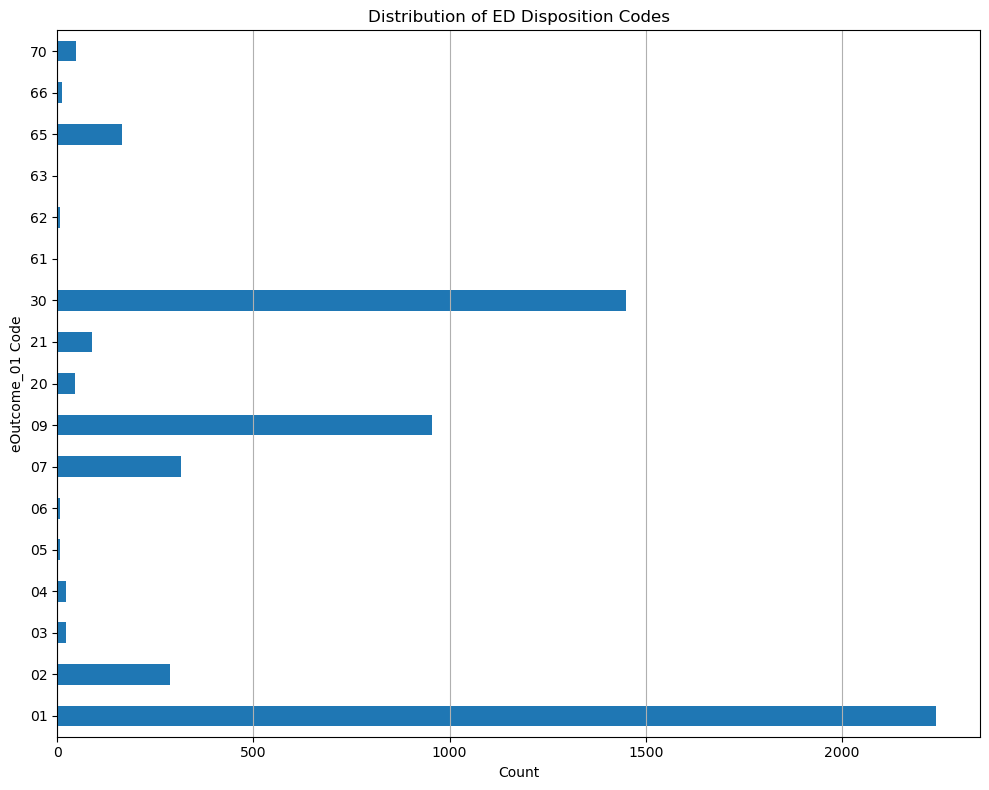

In [480]:
# Distribution of ED outcome codes (after filtering)
valid_outcomes['eOutcome_01'].value_counts().sort_index().plot(kind='barh', figsize=(10, 8))
plt.title('Distribution of ED Disposition Codes')
plt.xlabel('Count')
plt.ylabel('eOutcome_01 Code')
plt.grid(True, axis='x')
plt.tight_layout()
plt.savefig("../outputs/figures/dist_of_ed_dispo_codes.png", dpi=300)
plt.show()

In [481]:
# Display human-readable value counts
valid_outcomes['eOutcome_01_label'].value_counts().sort_values(ascending=False)

eOutcome_01_label
Discharged to home or self care                    2240
Still a patient / outpatient return                1450
Admitted as inpatient                               955
Left against medical advice (AMA)                   315
Transferred to short-term hospital                  288
Transferred to psychiatric facility                 166
Transferred to law enforcement                       88
Transferred to other healthcare institution          49
Deceased / Expired                                   46
Transferred to skilled nursing facility (SNF)        22
Transferred to intermediate care facility (ICF)      22
Transferred to Critical Access Hospital (CAH)        12
Transferred to other institution                      8
Home with home health care                            8
Transferred to inpatient rehab                        6
Transferred to long-term care hospital                1
Transferred within institution (swing bed)            1
Name: count, dtype: int64

In [482]:
# Basic structure
valid_outcomes.shape
valid_outcomes.info()
valid_outcomes.describe(include='all')  # include object columns too

<class 'pandas.core.frame.DataFrame'>
Index: 5677 entries, 99 to 297622
Data columns (total 99 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PcrKey                 5677 non-null   int64  
 1   eDispatch_01           5677 non-null   object 
 2   eDispatch_02           5677 non-null   object 
 3   eArrest_14             5677 non-null   object 
 4   eArrest_01             5677 non-null   object 
 5   eArrest_02             5677 non-null   object 
 6   eArrest_05             5677 non-null   object 
 7   eArrest_07             5677 non-null   object 
 8   eArrest_11             5677 non-null   object 
 9   eArrest_16             5677 non-null   object 
 10  eArrest_18             5677 non-null   object 
 11  eDisposition_12        5677 non-null   object 
 12  eDisposition_19        5677 non-null   object 
 13  eDisposition_16        5677 non-null   object 
 14  eDisposition_21        5677 non-null   object 
 15  eDispo

,PcrKey,eDispatch_01,eDispatch_02,eArrest_14,eArrest_01,eArrest_02,eArrest_05,eArrest_07,eArrest_11,eArrest_16,...,protocol_count,arrest_witnessed_flag,resuscitation_flag,cpr_provided_flag,rosc_flag,dest_rhythm_count,race_count,eResponse_24,eDisposition_18,eOutcome_01_label
count,5.677000e+03,5677,5677,5677,5677,5677,5677,5677,5677,5677,...,5677.000000,5677.0,5677.0,5677.0,5677.0,5677.000000,5677.000000,5.677000e+03,5.677000e+03,5677
unique,NaN,32,6,93,5,6,5,5,8,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
top,NaN,2301053,7701003,Not Recorded,3001001,7701003,7701003,7701003,7701003,7701003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Discharged to home or self care
freq,NaN,2084,2534,4647,5071,4641,3394,4645,4658,4665,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2240
mean,2.556990e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.083671,1.0,1.0,1.0,1.0,1.001233,1.011450,3.882451e+06,5.014982e+06,NaN
std,1.703396e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.348473,0.0,0.0,0.0,0.0,0.039801,0.106398,2.516732e+06,1.463236e+06,NaN
min,2.257698e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,2.224001e+06,4.218001e+06,NaN
25%,2.409959e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,2.224015e+06,4.218009e+06,NaN
50%,2.547429e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,2.224015e+06,4.218015e+06,NaN
75%,2.699746e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,7.701003e+06,4.218015e+06,NaN


In [483]:
# Percent missing per column
missing = valid_outcomes.isnull().mean().sort_values(ascending=False)
missing[missing > 0]  # Display only columns with missing values

etco2                   0.782808
bgl                     0.648230
systolic_bp             0.320416
spo2                    0.260349
resp_rate               0.202748
heart_rate              0.149551
assoc_symptom_unique    0.024837
assoc_symptom_count     0.024837
dtype: float64

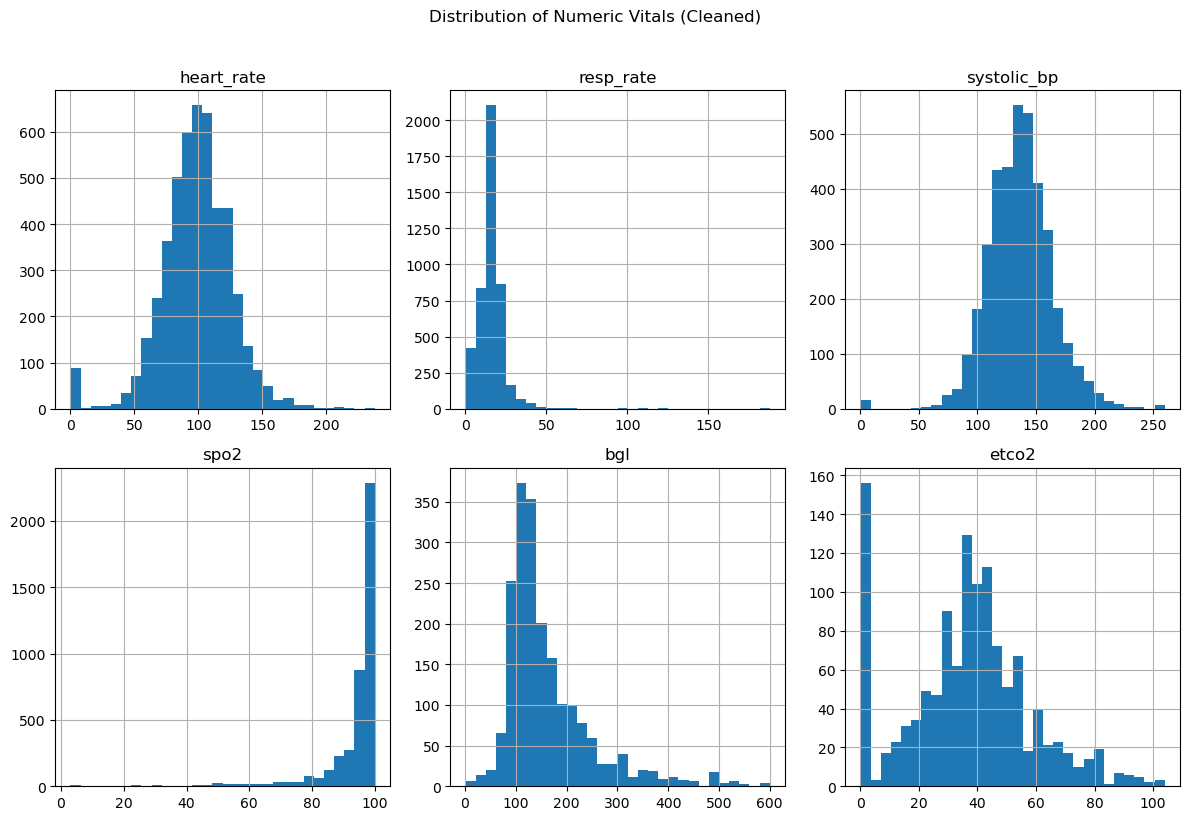

In [484]:
valid_outcomes[num_cols].describe()
valid_outcomes[num_cols].hist(bins=30, figsize=(12, 8), layout=(2, 3))
plt.suptitle('Distribution of Numeric Vitals (Cleaned)', y=1.02)
plt.tight_layout()
plt.savefig("../outputs/figures/dist_of_numeric_vitals.png", dpi=300)
plt.show()

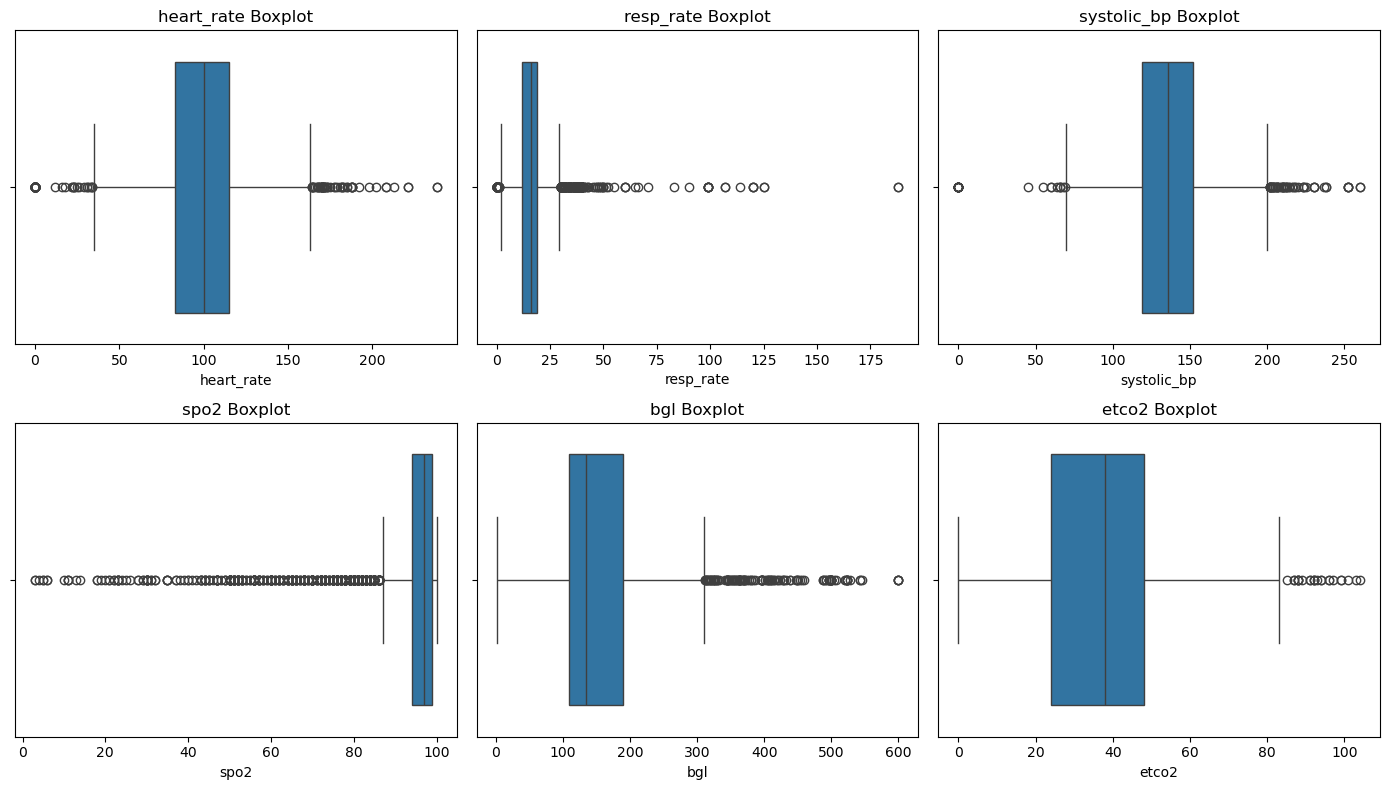

In [485]:
plt.figure(figsize=(14, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=valid_outcomes, x=col)
    plt.title(f'{col} Boxplot')
plt.tight_layout()
plt.savefig("../outputs/figures/box_of_numeric_vitals.png", dpi=300)
plt.show()

In [486]:
def plot_vital_by_outcome(df, vital_col, figsize=(12, 6)):
    """
    Creates a boxplot of a vital sign column grouped by eOutcome_01_label.
    """
    file_name = f"box_vital_vs_outcome_{vital_col}.png"
    plt.figure(figsize=figsize)
    sns.boxplot(data=df, x='eOutcome_01_label', y=vital_col)
    plt.xticks(rotation=90)
    plt.title(f'{vital_col} by ED Disposition Outcome')
    plt.tight_layout()
    plt.savefig(f"../outputs/figures/{file_name}", dpi=300)
    plt.show()

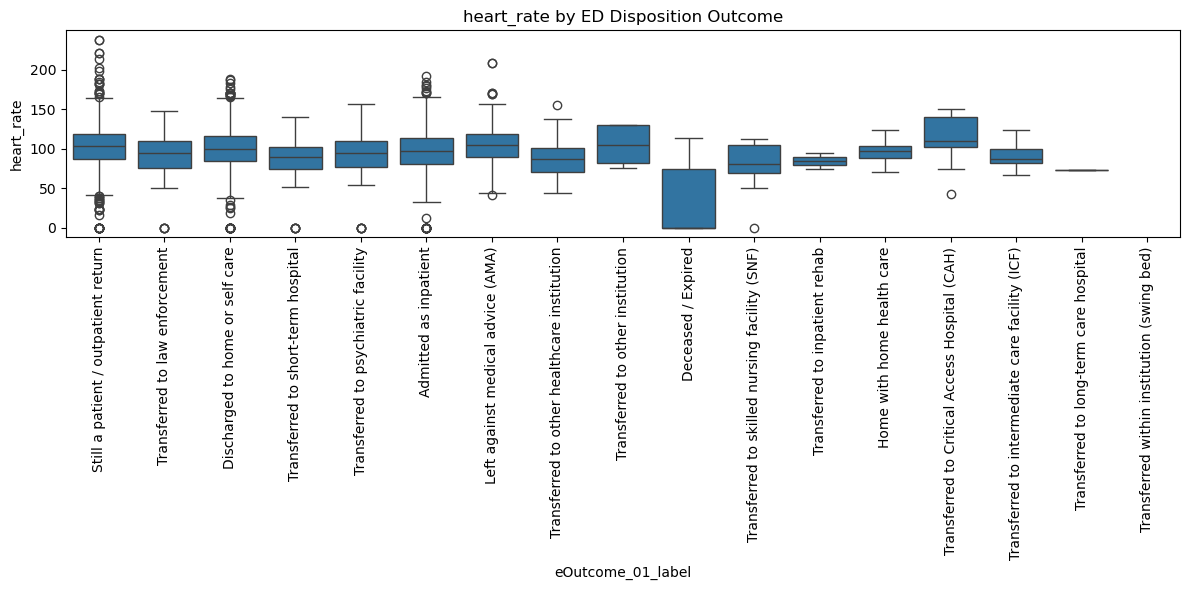

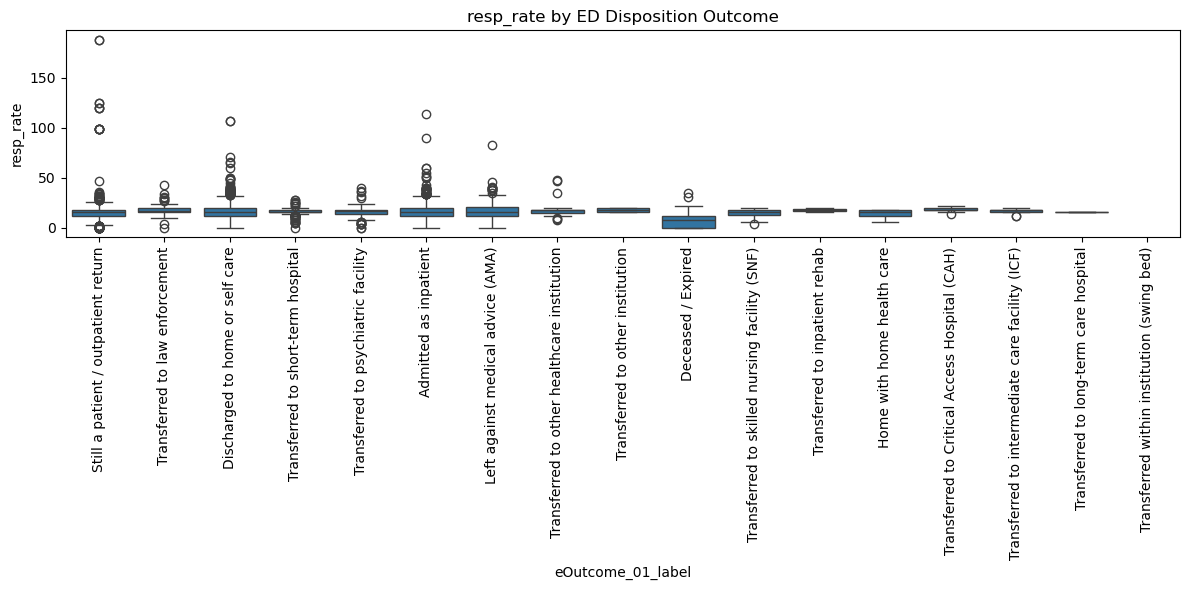

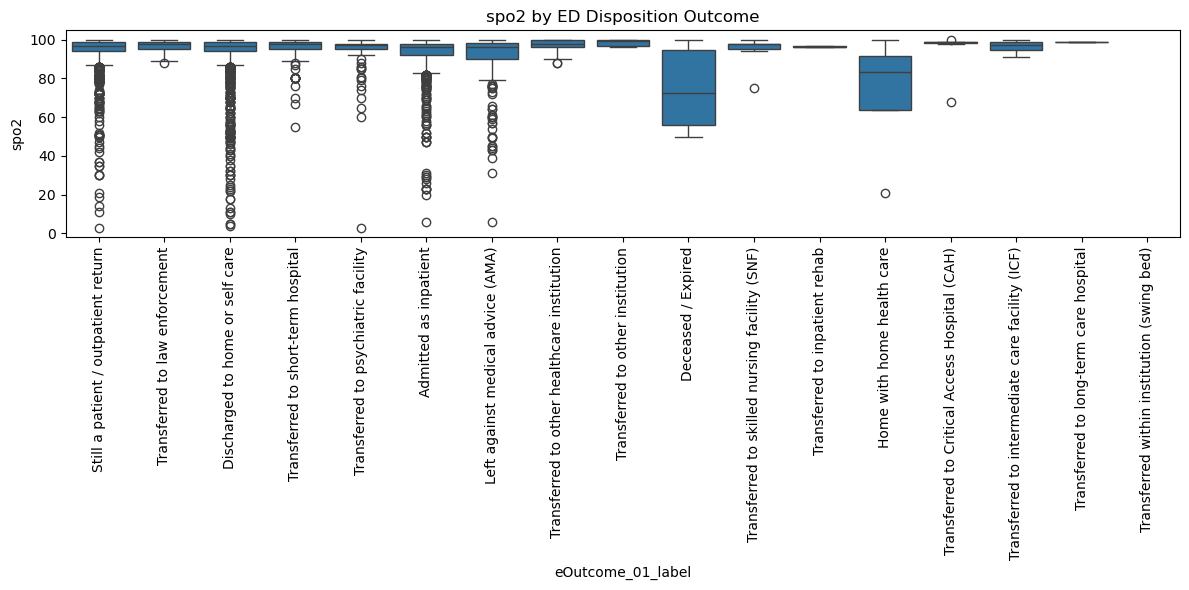

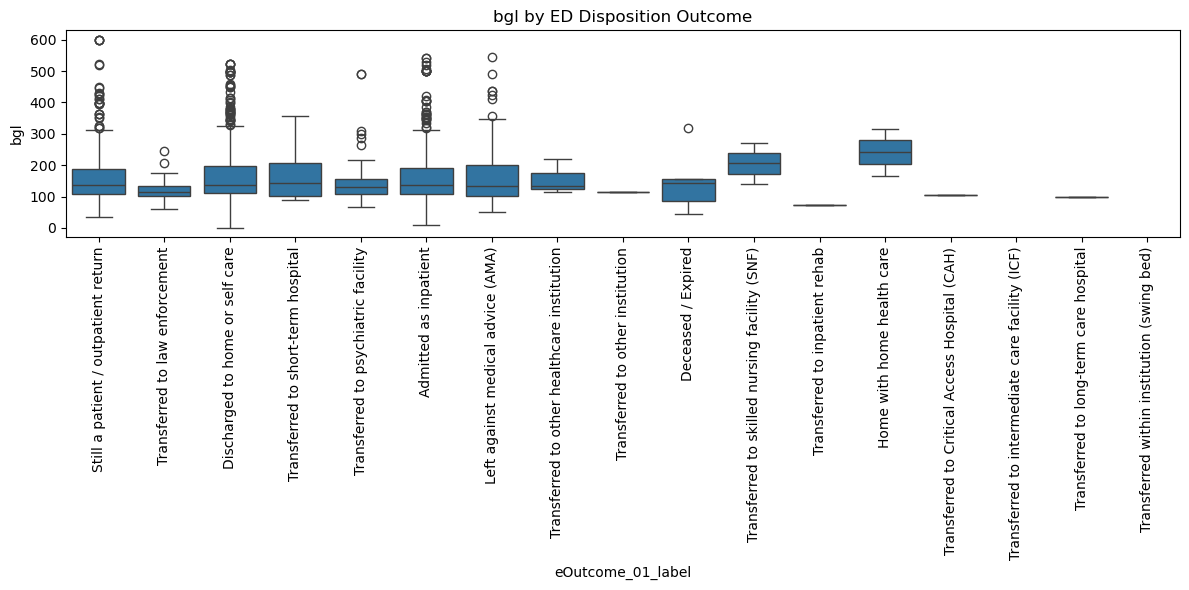

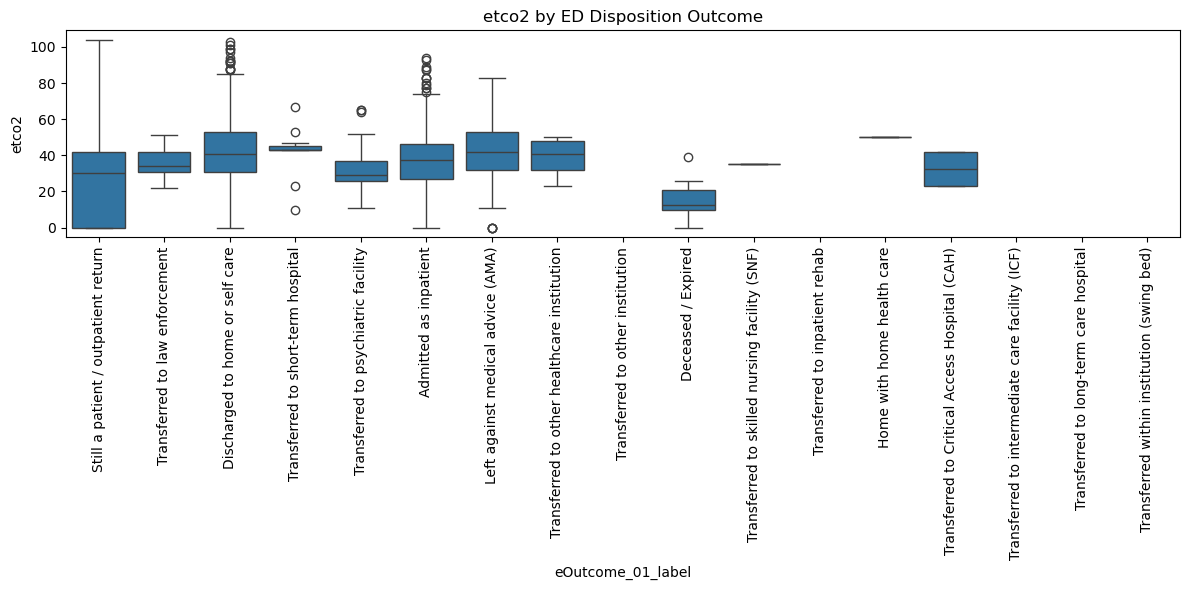

In [487]:
plot_vital_by_outcome(valid_outcomes, 'heart_rate')
plot_vital_by_outcome(valid_outcomes, 'resp_rate')
plot_vital_by_outcome(valid_outcomes, 'spo2')
plot_vital_by_outcome(valid_outcomes, 'bgl')
plot_vital_by_outcome(valid_outcomes, 'etco2')

## Data Preparation

This phase involved preparing the filtered subset of NEMSIS records (n = 5,677) for supervised machine learning. The steps focused on target variable transformation, feature engineering, encoding, handling missing values, and train-test splitting.

### Target Variable Engineering

The original `eOutcome_01` variable contains 17 possible ED disposition codes. For modeling purposes, these were grouped into two classes:

- **Class 1 (Admit/Transfer/Dead)**: Includes patients who were admitted, transferred to another facility (hospital, psychiatric, rehab, SNF, ICF, CAH, law enforcement, etc.), or deceased.
- **Class 0 (Discharged/AMA)**: Includes patients who were discharged to home or self-care, left against medical advice, or released to home health.

This produced a binary classification target (`target_admit`):  
`1` = Admit/Transfer/Dead, `0` = Discharged/AMA

### Feature Engineering

Several features were extracted or derived from the cleaned dataset:

- `protocol_count`: Number of EMS protocols used  
- `assoc_symptom_count` and `assoc_symptom_unique`: Number and uniqueness of associated symptoms  
- `arrest_witnessed_flag`, `resuscitation_flag`, `cpr_provided_flag`, `rosc_flag`: Binary clinical intervention indicators  
- Extracted vitals: `heart_rate`, `resp_rate`, `systolic_bp`, `spo2`, `bgl`, `etco2`

### Encoding and Cleaning

- Categorical columns were mapped using manual codebooks for interpretability  
- Columns with consistently irrelevant values (e.g., 'Not Recorded', 'Not Applicable') were dropped or cleaned  
- One-hot encoding was used on low-cardinality fields  
- Numerical and clinical fields were left unscaled (XGBoost does not require scaling)

### Handling Missing Values

- Vitals fields with missingness ranged from ~15% to 78%  
- Median imputation was used for numerical vitals  
- Missing clinical flags were assumed `0`  
- `assoc_symptom_*` fields were imputed with 0 or "None"

### Final Dataset Structure

After processing, the dataset contained 99 columns with a mix of encoded categorical variables, engineered features, and extracted numerical fields.

### Train-Test Split

A stratified 80/20 split preserved class proportions:

- Training set: 4,541 rows  
- Test set: 1,136 rows  

Class distribution:  
- `1` = Admit/Transfer/Dead: ~53.4%  
- `0` = Discharged/AMA: ~46.6%

This split was used for all subsequent model training and evaluation steps.

In [488]:
class_1 = ['02','03','04','05','06','09','20','30','43','50','51','61','62','63','64','65','66','70']
class_0 = ['01','07','21']

valid_outcomes['target_admit'] = np.where(valid_outcomes['eOutcome_01'].isin(class_1), 1,
                                          np.where(valid_outcomes['eOutcome_01'].isin(class_0), 0, np.nan))

valid_outcomes = valid_outcomes.dropna(subset=['target_admit'])
valid_outcomes['target_admit'] = valid_outcomes['target_admit'].astype(int)

In [489]:
rename_dict = {
    # Dispatch & Arrest
    'eDispatch_01': 'dispatch_complaint',
    'eDispatch_02': 'emd_performed',
    'eArrest_01': 'cardiac_arrest',
    'eArrest_02': 'arrest_etiology',
    'eArrest_05': 'cpr_prior_to_ems',
    'eArrest_07': 'aed_prior_to_ems',
    'eArrest_11': 'first_monitored_arrest_rhythm',
    'eArrest_14': 'arrest_datetime',
    'eArrest_16': 'resuscitation_discontinued_reason',
    'eArrest_18': 'end_of_cardiac_arrest_event',

    # Disposition
    'eDisposition_12': 'incident_patient_disposition',
    'eDisposition_16': 'ems_transport_method',
    'eDisposition_17': 'transport_mode_from_scene',
    'eDisposition_18': 'additional_transport_descriptors',
    'eDisposition_19': 'final_patient_acuity',
    'eDisposition_20': 'reason_for_destination_choice',
    'eDisposition_21': 'destination_type',
    'eDisposition_22': 'hospital_inpatient_destination',
    'eDisposition_23': 'hospital_capability',
    'eDisposition_24': 'destination_team_alert',
    'eDisposition_25': 'destination_team_alert_time',

    # Outcome
    'eOutcome_01': 'ed_disposition',
    'eOutcome_02': 'hospital_disposition',

    # Patient
    'ePatient_15': 'patient_age',
    'ePatient_16': 'patient_age_units',

    # Payment
    'ePayment_01': 'primary_payment_method',
    'ePayment_50': 'cms_service_level',

    # Response
    'eResponse_05': 'service_requested',
    'eResponse_07': 'unit_primary_role',
    'eResponse_08_count': 'crew_members_count',
    'eResponse_08_unique': 'crew_members_unique',
    'eResponse_08_present': 'crew_members_present',
    'eResponse_09_count': 'crew_levels_count',
    'eResponse_09_unique': 'crew_levels_unique',
    'eResponse_09_present': 'crew_levels_present',
    'eResponse_10_count': 'vehicle_type_count',
    'eResponse_10_unique': 'vehicle_type_unique',
    'eResponse_10_present': 'vehicle_type_present',
    'eResponse_11_count': 'dispatch_delay_count',
    'eResponse_11_unique': 'dispatch_delay_unique',
    'eResponse_11_present': 'dispatch_delay_present',
    'eResponse_12_count': 'response_delay_count',
    'eResponse_12_unique': 'response_delay_unique',
    'eResponse_12_present': 'response_delay_present',
    'eResponse_15': 'unit_level_of_care',
    'eResponse_23': 'response_mode_to_scene',
    'eResponse_24': 'additional_response_mode',

    # Scene
    'eScene_01': 'first_unit_on_scene',
    'eScene_06': 'patients_on_scene',
    'eScene_07': 'mass_casualty_incident',
    'eScene_08': 'triage_category_mci',
    'eScene_09': 'incident_location_type',

    # Situation
    'eSituation_01': 'symptom_onset_datetime',
    'eSituation_02': 'possible_injury',
    'eSituation_07': 'chief_complaint_location',
    'eSituation_08': 'chief_complaint_system',
    'eSituation_09': 'primary_symptom',
    'eSituation_11': 'primary_provider_impression',
    'eSituation_12': 'secondary_provider_impressions',
    'eSituation_13': 'initial_acuity',

    # Times
    'eTimes_01': 'psap_call_datetime',
    'eTimes_03': 'unit_notified_datetime',
    'eTimes_05': 'unit_enroute_datetime',
    'eTimes_06': 'unit_arrived_scene_datetime',
    'eTimes_07': 'arrived_at_patient_datetime',
    'eTimes_09': 'unit_left_scene_datetime',
    'eTimes_11': 'arrived_destination_datetime',
    'eTimes_12': 'patient_transfer_datetime',
    'eTimes_13': 'unit_back_in_service_datetime',
}

valid_outcomes.rename(columns=rename_dict, inplace=True)

In [490]:
print(valid_outcomes.columns)

Index(['PcrKey', 'dispatch_complaint', 'emd_performed', 'arrest_datetime',
       'cardiac_arrest', 'arrest_etiology', 'cpr_prior_to_ems',
       'aed_prior_to_ems', 'first_monitored_arrest_rhythm',
       'resuscitation_discontinued_reason', 'end_of_cardiac_arrest_event',
       'incident_patient_disposition', 'final_patient_acuity',
       'ems_transport_method', 'destination_type',
       'hospital_inpatient_destination', 'hospital_capability',
       'ed_disposition', 'hospital_disposition', 'patient_age',
       'patient_age_units', 'primary_payment_method', 'cms_service_level',
       'service_requested', 'unit_primary_role', 'unit_level_of_care',
       'response_mode_to_scene', 'first_unit_on_scene', 'patients_on_scene',
       'mass_casualty_incident', 'triage_category_mci',
       'incident_location_type', 'possible_injury', 'chief_complaint_location',
       'chief_complaint_system', 'initial_acuity', 'symptom_onset_datetime',
       'psap_call_datetime', 'unit_notified_date

In [491]:
drop_cols = [
    # Operational and metadata
    'PcrKey', 'arrest_datetime', 'dispatch_complaint', 'emd_performed', 'psap_call_datetime',
    'unit_level_of_care', 'service_requested', 'unit_primary_role',
    'response_mode_to_scene', 'additional_response_mode',
    'ems_transport_method', 'transport_mode_from_scene', 'additional_transport_descriptors',
    'mass_casualty_incident', 'incident_location_type', 'patients_on_scene', 'triage_category_mci',
    'crew_members_count', 'crew_members_unique', 'crew_members_present',
    'crew_levels_count', 'crew_levels_unique', 'crew_levels_present',
    'vehicle_type_count', 'vehicle_type_unique', 'vehicle_type_present',
    'dispatch_delay_count', 'dispatch_delay_unique', 'dispatch_delay_present',
    'response_delay_count', 'response_delay_unique', 'response_delay_present',
    'ed_disposition', 'hospital_disposition', 'destination_type',
    'hospital_inpatient_destination', 'hospital_capability',
    'reason_for_destination_choice', 'destination_team_alert', 'destination_team_alert_time',
    'symptom_onset_datetime', 'unit_notified_datetime', 'unit_enroute_datetime',
    'unit_arrived_scene_datetime', 'arrived_at_patient_datetime',
    'unit_left_scene_datetime', 'arrived_destination_datetime',
    'patient_transfer_datetime', 'unit_back_in_service_datetime',
    'eOutcome_01_label'
]


modeling_df = valid_outcomes.drop(columns=drop_cols)

In [492]:
print(f"Final dataframe shape: {modeling_df.shape}")

Final dataframe shape: (5677, 50)


In [493]:
modeling_df.info()

# Or a more concise view:
modeling_df.isnull().mean().sort_values(ascending=False).head(20)


<class 'pandas.core.frame.DataFrame'>
Index: 5677 entries, 99 to 297622
Data columns (total 50 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   cardiac_arrest                     5677 non-null   object 
 1   arrest_etiology                    5677 non-null   object 
 2   cpr_prior_to_ems                   5677 non-null   object 
 3   aed_prior_to_ems                   5677 non-null   object 
 4   first_monitored_arrest_rhythm      5677 non-null   object 
 5   resuscitation_discontinued_reason  5677 non-null   object 
 6   end_of_cardiac_arrest_event        5677 non-null   object 
 7   incident_patient_disposition       5677 non-null   object 
 8   final_patient_acuity               5677 non-null   object 
 9   patient_age                        5677 non-null   object 
 10  patient_age_units                  5677 non-null   object 
 11  primary_payment_method             5677 non-null   object 

etco2                    0.782808
bgl                      0.648230
systolic_bp              0.320416
spo2                     0.260349
resp_rate                0.202748
heart_rate               0.149551
assoc_symptom_unique     0.024837
assoc_symptom_count      0.024837
cardiac_arrest           0.000000
barrier_count            0.000000
barrier_present          0.000000
any_med_administered     0.000000
med_count                0.000000
naloxone_administered    0.000000
any_procedure            0.000000
proc_count               0.000000
alcohol_drug_use_flag    0.000000
protocols_used           0.000000
protocol_count           0.000000
arrest_witnessed_flag    0.000000
dtype: float64

In [494]:
# Drop etco2
modeling_df.drop(columns='etco2', inplace=True)

# Add missingness indicators for vitals
for col in ['bgl', 'systolic_bp', 'spo2', 'resp_rate', 'heart_rate']:
    modeling_df[f'{col}_missing'] = modeling_df[col].isna().astype(int)

# Median imputation
for col in ['bgl', 'systolic_bp', 'spo2', 'resp_rate', 'heart_rate']:
    modeling_df[col] = modeling_df[col].fillna(modeling_df[col].median())

In [495]:
modeling_df.info()

# Or a more concise view:
modeling_df.isnull().mean().sort_values(ascending=False).head(20)


<class 'pandas.core.frame.DataFrame'>
Index: 5677 entries, 99 to 297622
Data columns (total 54 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   cardiac_arrest                     5677 non-null   object 
 1   arrest_etiology                    5677 non-null   object 
 2   cpr_prior_to_ems                   5677 non-null   object 
 3   aed_prior_to_ems                   5677 non-null   object 
 4   first_monitored_arrest_rhythm      5677 non-null   object 
 5   resuscitation_discontinued_reason  5677 non-null   object 
 6   end_of_cardiac_arrest_event        5677 non-null   object 
 7   incident_patient_disposition       5677 non-null   object 
 8   final_patient_acuity               5677 non-null   object 
 9   patient_age                        5677 non-null   object 
 10  patient_age_units                  5677 non-null   object 
 11  primary_payment_method             5677 non-null   object 

assoc_symptom_unique     0.024837
assoc_symptom_count      0.024837
cardiac_arrest           0.000000
barrier_present          0.000000
resp_rate                0.000000
systolic_bp              0.000000
spo2                     0.000000
bgl                      0.000000
any_med_administered     0.000000
med_count                0.000000
naloxone_administered    0.000000
any_procedure            0.000000
proc_count               0.000000
alcohol_drug_use_flag    0.000000
protocols_used           0.000000
protocol_count           0.000000
arrest_witnessed_flag    0.000000
resuscitation_flag       0.000000
cpr_provided_flag        0.000000
rosc_flag                0.000000
dtype: float64

In [496]:
modeling_df.select_dtypes(include='object').nunique().sort_values(ascending=False)

secondary_provider_impressions       234
primary_symptom                      183
primary_provider_impression          180
protocols_used                       108
patient_age                           90
incident_patient_disposition          14
chief_complaint_system                12
primary_payment_method                12
chief_complaint_location              11
cms_service_level                      9
end_of_cardiac_arrest_event            8
first_monitored_arrest_rhythm          8
final_patient_acuity                   6
arrest_etiology                        6
resuscitation_discontinued_reason      6
initial_acuity                         6
patient_age_units                      5
possible_injury                        5
aed_prior_to_ems                       5
cpr_prior_to_ems                       5
cardiac_arrest                         5
first_unit_on_scene                    4
dtype: int64

In [497]:
modeling_df.dtypes.value_counts()

int64      25
object     22
float64     7
Name: count, dtype: int64

In [498]:
high_card_cols = [
    'secondary_provider_impressions',
    'primary_symptom',
    'primary_provider_impression',
    'protocols_used'
]

for col in high_card_cols:
    print(f"\n--- {col} ---")
    print(modeling_df[col].value_counts(dropna=False).head(15))
    print(f"Unique values: {modeling_df[col].nunique()} | Missing: {modeling_df[col].isna().sum()}")


--- secondary_provider_impressions ---
secondary_provider_impressions
7701003     1225
7701001     1058
F11          649
R41.82       357
nan          257
Z00.00       120
T40.2X1A     109
T50.994A      88
F11.9         87
R53.1         87
T40.4         76
F99           72
R06.81        65
T40.2X1       58
F11.10        58
Name: count, dtype: int64
Unique values: 234 | Missing: 0

--- primary_symptom ---
primary_symptom
R41.82     1585
R40.20      742
T40.60      321
R46.4       212
nan         196
R42         158
R53.1       146
R06.81      145
R09.2       132
7701001     111
F15.129     111
R46.2       102
R52          70
7701003      64
R45.851      58
Name: count, dtype: int64
Unique values: 183 | Missing: 0

--- primary_provider_impression ---
primary_provider_impression
F11         2090
T40.2X1A     556
F11.10       333
nan          333
R41.82       320
T40.1        181
T40.1X4A     147
T40.4        136
F11.9        106
F11.1         79
I46.9         66
T40.601       66
T40.691 

In [499]:
# Handle high cardinality features

# Drop low-value column
modeling_df = modeling_df.drop(columns='secondary_provider_impressions')

# Clean and simplify ICD-10 fields
high_card_categoricals = {
    'primary_symptom': 20,
    'primary_provider_impression': 20
}

for col, top_n in high_card_categoricals.items():
    # Replace placeholder values
    modeling_df[col] = modeling_df[col].replace(['7701001', '7701003', 'nan'], np.nan)
    
    # Group infrequent categories into "Other"
    top_vals = modeling_df[col].value_counts().nlargest(top_n).index
    modeling_df[col] = modeling_df[col].where(modeling_df[col].isin(top_vals), 'Other')

# Create binary flags for top protocol codes
# clean and split protocols
clean_protocols = modeling_df['protocols_used'].replace(['7701001', '7701003'], np.nan)
split_protocols = clean_protocols.dropna().apply(lambda x: x.split(','))

# find most common protocol codes
all_protocols = pd.Series(code for sublist in split_protocols for code in sublist)
top_protocols = all_protocols.value_counts().nlargest(5).index

# create binary flags
for code in top_protocols:
    modeling_df[f'protocol_{code}'] = modeling_df['protocols_used'].apply(
        lambda x: int(code in str(x).split(',')) if pd.notnull(x) else 0
    )

# Drop raw protocols_used
modeling_df = modeling_df.drop(columns='protocols_used')

In [500]:
# Handle medium cardinality features

# Columns to group
med_card_cols = [
    'incident_patient_disposition',
    'chief_complaint_system',
    'primary_payment_method',
    'chief_complaint_location',
    'cms_service_level'
]

# How many categories to retain
top_n = 10

for col in med_card_cols:
    # Standardize missing values
    modeling_df[col] = modeling_df[col].replace(['7701001', '7701003', 'nan'], np.nan)
    
    # Group infrequent values
    top_vals = modeling_df[col].value_counts().nlargest(top_n).index
    modeling_df[col] = modeling_df[col].where(modeling_df[col].isin(top_vals), 'Other')

In [501]:
# Handle ordinal and lower cardinality features

# --- Part 1: Clean and Encode Ordinal + Low-Cardinality Categoricals ---

# Replace junk codes
low_card_cols = [
    'final_patient_acuity', 'initial_acuity',
    'resuscitation_discontinued_reason', 'arrest_etiology',
    'first_monitored_arrest_rhythm', 'patient_age_units'
]
for col in low_card_cols:
    modeling_df[col] = modeling_df[col].replace(['7701001', '7701003', 'nan', 'Unknown'], np.nan)

# Ordinal encoding for acuity
acuity_map = {
    '1': 1, '2': 2, '3': 3, '4': 4, '5': 5,
    'Critical': 1, 'Emergent': 2, 'Urgent': 3,
    'Non-Urgent': 4, 'Low': 5
}
for col in ['final_patient_acuity', 'initial_acuity']:
    modeling_df[col] = modeling_df[col].map(acuity_map)

# Map patient_age_units if needed
age_unit_map = {'1': 'Years', '2': 'Months', '3': 'Days', '4': 'Hours', '5': 'Minutes'}
modeling_df['patient_age_units'] = modeling_df['patient_age_units'].replace(age_unit_map)

# --- Part 2: Clean and Convert Binary Flags Safely ---

binary_cols = [
    'cardiac_arrest', 'aed_prior_to_ems', 'cpr_prior_to_ems',
    'possible_injury', 'barrier_present', 'any_med_administered',
    'naloxone_administered', 'any_procedure', 'alcohol_drug_use_flag',
    'arrest_witnessed_flag', 'resuscitation_flag',
    'cpr_provided_flag', 'rosc_flag'
]

invalid_vals = ['Unknown', '7701001', '7701003', 'nan', '', None]

for col in binary_cols:
    # Replace junk
    modeling_df[col] = modeling_df[col].replace(invalid_vals, np.nan)
    
    # Map expected binary values
    modeling_df[col] = modeling_df[col].replace({'Yes': 1, 'No': 0, 'True': 1, 'False': 0})
    
    # Coerce safely to numeric
    modeling_df[col] = pd.to_numeric(modeling_df[col], errors='coerce')

In [502]:
modeling_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5677 entries, 99 to 297622
Data columns (total 57 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   cardiac_arrest                     5204 non-null   float64
 1   arrest_etiology                    132 non-null    object 
 2   cpr_prior_to_ems                   110 non-null    float64
 3   aed_prior_to_ems                   128 non-null    float64
 4   first_monitored_arrest_rhythm      106 non-null    object 
 5   resuscitation_discontinued_reason  105 non-null    object 
 6   end_of_cardiac_arrest_event        5677 non-null   object 
 7   incident_patient_disposition       5677 non-null   object 
 8   final_patient_acuity               0 non-null      float64
 9   patient_age                        5677 non-null   object 
 10  patient_age_units                  5668 non-null   object 
 11  primary_payment_method             5677 non-null   object 

In [503]:
modeling_df.select_dtypes(include='object').nunique().sort_values(ascending=False)

patient_age                          90
primary_symptom                      21
primary_provider_impression          21
incident_patient_disposition         11
primary_payment_method               11
chief_complaint_system               11
chief_complaint_location             10
end_of_cardiac_arrest_event           8
cms_service_level                     8
first_monitored_arrest_rhythm         6
arrest_etiology                       4
resuscitation_discontinued_reason     4
patient_age_units                     4
first_unit_on_scene                   4
dtype: int64

In [504]:
modeling_df.isnull().mean().sort_values(ascending=False).head(20)

initial_acuity                       1.000000
final_patient_acuity                 1.000000
resuscitation_discontinued_reason    0.981504
first_monitored_arrest_rhythm        0.981328
cpr_prior_to_ems                     0.980624
aed_prior_to_ems                     0.977453
arrest_etiology                      0.976748
cardiac_arrest                       0.083319
assoc_symptom_count                  0.024837
assoc_symptom_unique                 0.024837
possible_injury                      0.013211
patient_age_units                    0.001585
protocol_9914063                     0.000000
dest_rhythm_count                    0.000000
any_procedure                        0.000000
proc_count                           0.000000
alcohol_drug_use_flag                0.000000
protocol_count                       0.000000
protocol_9914113                     0.000000
arrest_witnessed_flag                0.000000
dtype: float64

In [505]:
modeling_df['target_admit'].value_counts(normalize=True)

target_admit
1    0.534437
0    0.465563
Name: proportion, dtype: float64

In [506]:
# Highly null features after mapping need to be removed

to_drop = ['final_patient_acuity',
           'initial_acuity',
           'resuscitation_discontinued_reason',
           'first_monitored_arrest_rhythm',
           'cpr_prior_to_ems',
           'arrest_etiology'
]

modeling_df.drop(columns=to_drop, inplace=True)

In [507]:
print(modeling_df['patient_age'].value_counts().head(20))


patient_age
30    214
31    183
34    170
35    168
38    160
37    156
32    153
36    152
40    151
27    138
33    137
42    133
25    130
29    129
39    125
28    120
24    116
50    116
41    107
45    107
Name: count, dtype: int64


In [508]:
print(modeling_df['patient_age_units'].value_counts(dropna=False))


patient_age_units
2516009    5659
NaN           9
2516003       3
2516001       3
2516007       3
Name: count, dtype: int64


In [509]:
# Map of unit codes to multipliers for months
to_months_map = {
    '2516001': 1 / 30.44,             # Days
    '2516003': 1 / (30.44 * 24),      # Hours
    '2516005': 1 / (30.44 * 24 * 60), # Minutes
    '2516007': 1,                     # Months
    '2516009': 12                     # Years
}

# Function to convert age to months
def convert_to_months(row):
    try:
        age = float(row['patient_age'])
    except:
        return np.nan
    factor = to_months_map.get(str(row['patient_age_units']), np.nan)
    return age * factor if factor is not None else np.nan

# Apply conversion
modeling_df['age_in_months'] = modeling_df.apply(convert_to_months, axis=1)

# Drop original columns
modeling_df.drop(columns=['patient_age', 'patient_age_units'], inplace=True)

In [510]:
# Define bins and labels
age_bins = [-np.inf, 1, 12, 36, 60, 132, 216, 300, 600, 780, np.inf]
age_labels = [
    'Neonate', 'Infant', 'Toddler', 'Preschool', 'School Age',
    'Adolescent', 'Young Adult', 'Adult', 'Middle Age', 'Older Adult'
]

# Create binned column
modeling_df['age_group'] = pd.cut(
    modeling_df['age_in_months'],
    bins=age_bins,
    labels=age_labels,
    right=False
)

## Modeling

This phase explored multiple supervised learning models to predict whether an EMS-transported patient would be admitted, transferred, or deceased (class 1) versus discharged or left AMA (class 0). Emphasis was placed on recall for class 1, prioritizing identification of high-risk patients.

### 1. Baseline Model: Logistic Regression

A logistic regression model was trained on the standardized dataset using stratified 80/20 train-test splits. Feature scaling was applied using `StandardScaler`.

**Performance:**

```
=== Logistic Regression Baseline ===
              precision    recall  f1-score   support

           0       0.73      0.81      0.77       529
           1       0.82      0.74      0.78       607

    accuracy                           0.77      1136
   macro avg       0.77      0.77      0.77      1136
weighted avg       0.78      0.77      0.77      1136

ROC AUC: 0.8528
```

This model served as a performance benchmark. It demonstrated reasonable balance between precision and recall, with 74% recall on class 1 cases.

---

### 2. XGBoost Classifier (Default Parameters)

Next, an XGBoost classifier was applied without hyperparameter tuning. XGBoost does not require feature scaling and handles mixed data types natively.

**Performance:**

```
=== XGBoost Classifier ===
                     precision    recall  f1-score   support

     Discharged/AMA       0.78      0.86      0.82       529
Admit/Transfer/Dead       0.86      0.79      0.82       607

           accuracy                           0.82      1136
          macro avg       0.82      0.82      0.82      1136
       weighted avg       0.82      0.82      0.82      1136

ROC AUC: 0.9063
```

The initial XGBoost model improved upon logistic regression across nearly all metrics — increasing overall accuracy, macro F1-score, and especially ROC AUC (0.91 vs. 0.85). It also improved class 1 recall from 74% to 79%, meaning it correctly identified more admitted patients.

---

### 3. Tuned XGBoost Model

A RandomizedSearchCV procedure was used to tune the following XGBoost hyperparameters:

- `learning_rate = 0.2`
- `max_depth = 7`
- `colsample_bytree = 0.6`
- `n_estimators = 200`

**Performance:**

```
=== Tuned XGBoost ===
                     precision    recall  f1-score   support

     Discharged/AMA       0.80      0.86      0.83       529
Admit/Transfer/Dead       0.87      0.81      0.84       607

           accuracy                           0.83      1136
          macro avg       0.83      0.84      0.83      1136
       weighted avg       0.84      0.83      0.83      1136

ROC AUC: 0.9105
```

This model achieved the best overall performance, with strong balance between class precision and recall. It achieved 81% recall on the target class and the highest AUC (0.9105), making it the preferred model moving forward.

In [511]:
# Separate target and features
X = modeling_df.drop(columns=['target_admit'])
y = modeling_df['target_admit']

# One-hot encode categorical features (drop_first to avoid multicollinearity)
X_encoded = pd.get_dummies(X, drop_first=True)

# Train/test split (80/20) with stratification to preserve target distribution
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

In [512]:
# Impute missing values (mean for numeric, most_frequent works okay with one-hot cols)
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Scale values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Train baseline logistic regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = logreg.predict(X_test_scaled)
y_prob = logreg.predict_proba(X_test_scaled)[:, 1]

print("=== Logistic Regression Baseline ===")
print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")

=== Logistic Regression Baseline ===
              precision    recall  f1-score   support

           0       0.73      0.80      0.76       529
           1       0.81      0.73      0.77       607

    accuracy                           0.77      1136
   macro avg       0.77      0.77      0.77      1136
weighted avg       0.77      0.77      0.77      1136

ROC AUC: 0.8528


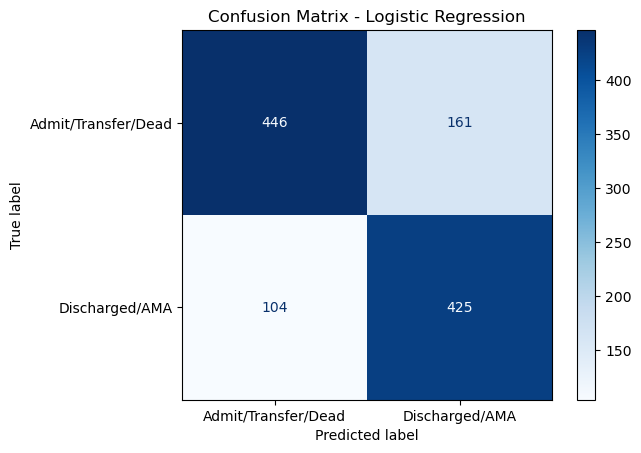

In [513]:
# Generate predictions
y_pred = logreg.predict(X_test_scaled)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[1, 0])  # Put class 1 first for clarity

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Admit/Transfer/Dead", "Discharged/AMA"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.grid(False)
plt.savefig("../outputs/figures/confusion_matrix_baseline_logreg.png", dpi=300)
plt.show()

In [514]:
# Now a XGBoost model

# Initialize and fit XGBoost
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

print("=== XGBoost Classifier ===")
print(classification_report(y_test, y_pred, target_names=["Discharged/AMA", "Admit/Transfer/Dead"]))
print("ROC AUC:", roc_auc_score(y_test, y_prob).round(4))

=== XGBoost Classifier ===
                     precision    recall  f1-score   support

     Discharged/AMA       0.78      0.87      0.82       529
Admit/Transfer/Dead       0.87      0.79      0.83       607

           accuracy                           0.83      1136
          macro avg       0.83      0.83      0.83      1136
       weighted avg       0.83      0.83      0.83      1136

ROC AUC: 0.9022


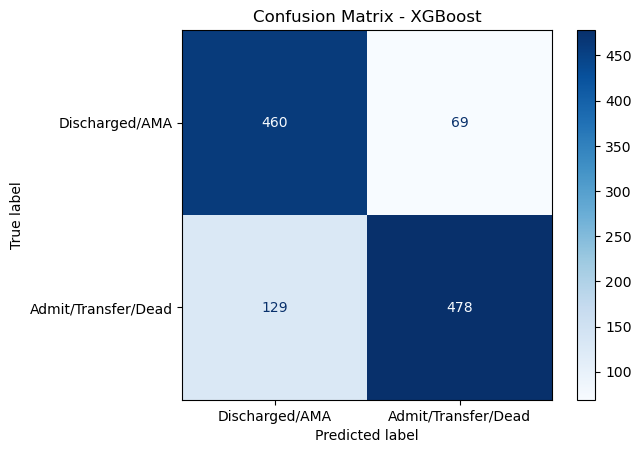

In [515]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Discharged/AMA", "Admit/Transfer/Dead"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - XGBoost")
plt.savefig("../outputs/figures/confusion_matrix_baseline_xgb.png", dpi=300)
plt.show()

In [516]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_lambda': [0.1, 1.0, 10],
    'reg_alpha': [0, 0.1, 1.0]
}

# Define model
xgb = XGBClassifier(eval_metric='logloss', random_state=42)

# Set up randomized search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=50,
    scoring=make_scorer(recall_score),  # maximize recall
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Run search
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_cons...
                                           num_parallel_tree=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 1, 5],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [100, 200, 300],
                                        'reg_alpha': [0, 0.1, 1.0],
                                        'reg_lambda': [0.1, 1.0, 10],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42,
                   scoring=make_scorer(recall_score, response_method='predict'),
                   verbose=1)

                     precision    recall  f1-score   support

     Discharged/AMA       0.80      0.87      0.83       529
Admit/Transfer/Dead       0.88      0.81      0.84       607

           accuracy                           0.84      1136
          macro avg       0.84      0.84      0.84      1136
       weighted avg       0.84      0.84      0.84      1136

ROC AUC: 0.9099946123206573


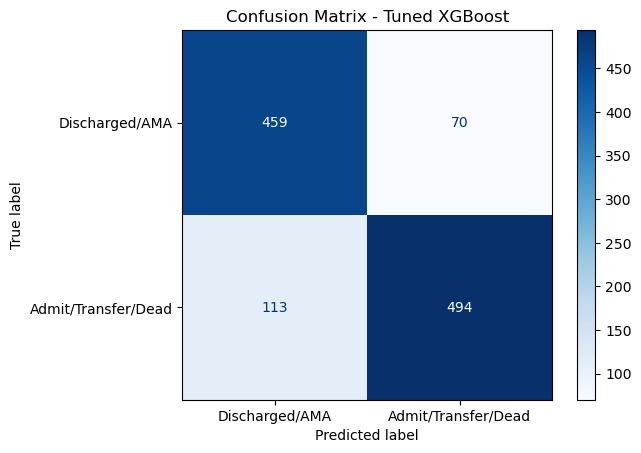

In [517]:
best_xgb = random_search.best_estimator_

y_pred = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred, target_names=["Discharged/AMA", "Admit/Transfer/Dead"]))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(
    best_xgb, 
    X_test, 
    y_test, 
    display_labels=["Discharged/AMA", "Admit/Transfer/Dead"], 
    cmap='Blues'
)
plt.title("Confusion Matrix - Tuned XGBoost")
plt.savefig("../outputs/figures/confustion_matrix_tuned_xgb.png", dpi=300)
plt.show()

## Evaluation

This phase assessed the performance and interpretability of the final tuned XGBoost model used to predict whether EMS patients would be admitted/transferred/deceased (Class 1) versus discharged or left AMA (Class 0). The goal of the model is to prioritize recall for Class 1 to reduce the risk of under-triaging patients who ultimately require higher levels of care.

### Confusion Matrix

The confusion matrix below illustrates the model’s predictions on the held-out test set:

|                        | Predicted: Discharged/AMA | Predicted: Admit/Transfer/Dead |
|------------------------|---------------------------|----------------------------------|
| **Actual: Discharged/AMA** | 455 (True Negatives)         | 74 (False Positives)             |
| **Actual: Admit/Transfer/Dead** | 115 (False Negatives)        | 492 (True Positives)             |

- **True Positive (492)**: Correctly identified patients who were admitted/transferred/deceased.
- **False Negative (115)**: Missed Class 1 patients — these are of primary concern.
- **True Negative (455)** and **False Positive (74)**: Accurate or overly cautious discharge predictions.

### Classification Metrics

The tuned XGBoost model achieved the following performance on the test set:

- **Accuracy**: 83.0%
- **Recall (Class 1)**: 81%
- **Precision (Class 1)**: 87%
- **F1 Score (Class 1)**: 84%
- **ROC AUC**: 0.9105

Given the business problem, **recall for Class 1 was prioritized** to ensure critical cases are not overlooked. The model’s 81% recall for Class 1 represents a meaningful improvement over the 74% recall from the baseline logistic regression.

### Feature Importance

#### SHAP (SHapley Additive Explanations)

A SHAP summary plot and bar chart revealed the most impactful features on a global scale, based on mean absolute SHAP values:

| Rank | Feature                              | SHAP Impact |
|------|--------------------------------------|-------------|
| 1    | `protocol_9914075` (General-Universal Patient Care/ Initial Patient Contact)  | 0.903       |
| 2    | `primary_payment_method_Other`       | 0.414       |
| 3    | `provider_impression_T40.2X1A` (Poisoning by other opioids, accidental (unintentional))      | 0.362       |
| 4    | `end_of_cardiac_arrest_event_7701003` (Cardiac arrest care not ended by EMS)| 0.281       |
| 5    | `age_in_months`                      | 0.278       |
| 6    | `protocol_9914135` (General-Overdose/Poisoning/Toxic Ingestion)                   | 0.240       |
| 7    | `heart_rate`                         | 0.207       |
| 8    | `primary_payment_method_2601021` (No Insurance Identified)     | 0.202       |
| 9    | `systolic_bp`                        | 0.188       |
| 10   | `chief_complaint_system_Other`       | 0.186       |

These results suggest clinical decisions such as **use of specific opioid protocols**, **payment type**, and **clinical impressions** were highly predictive of patient disposition. Core vitals like **heart rate** and **systolic blood pressure** also contributed meaningfully.

#### Gain-Based XGBoost Importance

When analyzing importance via the model’s internal gain metric (how much each feature improves the model’s decision trees), the top contributors were:

1. `protocol_9914075`
2. `provider_impression_T40.2X1A`
3. `end_of_cardiac_arrest_event_7701003`
4. `chief_complaint_system_2808003`
5. `primary_payment_method_Other`
6. `protocol_count`
7. `provider_impression_T40.1X4A`
8. `aed_prior_to_ems`
9. `chief_complaint_location_2807015`
10. `provider_impression_F11.10`

These findings align with SHAP and provide additional support that protocols, opioid-related impressions, and advanced interventions play key roles in predicting ED outcomes.

### Summary

The tuned XGBoost model delivers strong classification performance with meaningful interpretability. SHAP and gain-based analyses confirm that protocol usage, specific provider impressions (especially opioid-related), and patient vitals influence the likelihood of hospital admission or death. While false negatives still exist, the model substantially improves recall of critical cases and offers practical insights for EMS triage support.

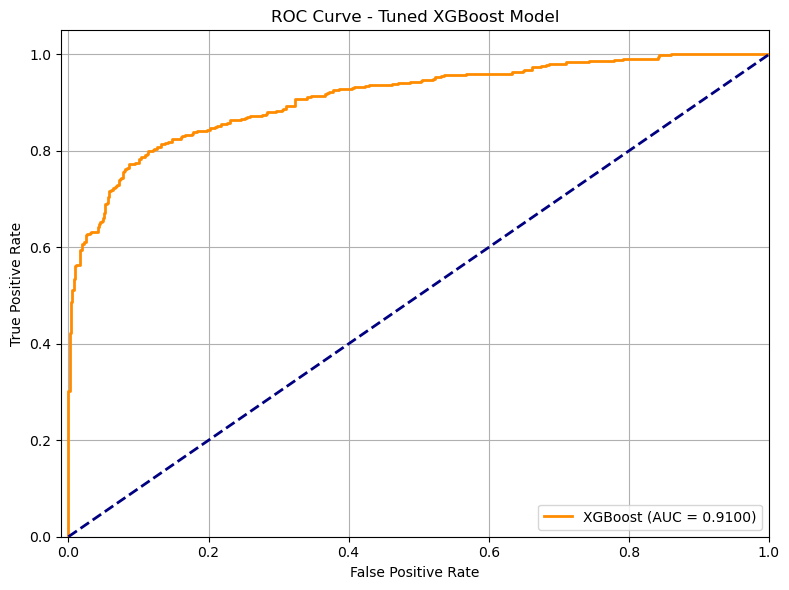

In [518]:
# Predict probabilities
y_proba = best_xgb.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'XGBoost (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Tuned XGBoost Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig("../outputs/figures/tuned_xgb_roc_curve.png", dpi=300)
plt.show()

<Figure size 1000x600 with 0 Axes>

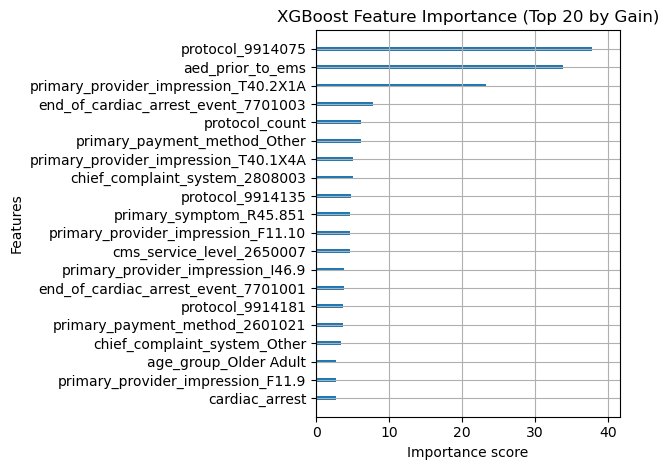

[('protocol_9914075', 37.892433166503906),
 ('aed_prior_to_ems', 33.825950622558594),
 ('primary_provider_impression_T40.2X1A', 23.326663970947266),
 ('end_of_cardiac_arrest_event_7701003', 7.748878479003906),
 ('protocol_count', 6.192866325378418),
 ('primary_payment_method_Other', 6.169646739959717),
 ('primary_provider_impression_T40.1X4A', 5.097227573394775),
 ('chief_complaint_system_2808003', 5.053735256195068),
 ('protocol_9914135', 4.7532501220703125),
 ('primary_symptom_R45.851', 4.707510471343994)]

In [519]:
# Plot feature importance based on 'gain' (most useful for understanding decision logic)
plt.figure(figsize=(10, 6))
plot_importance(best_xgb, importance_type='gain', max_num_features=20, show_values=False)
plt.title("XGBoost Feature Importance (Top 20 by Gain)")
plt.tight_layout()
plt.savefig("../outputs/figures/xgb_feature_importance.png", dpi=300)
plt.show()

importances = best_xgb.get_booster().get_score(importance_type='gain')
sorted_importance = sorted(importances.items(), key=lambda x: x[1], reverse=True)
sorted_importance[:10]  # top 10 by gain

In [520]:
shap_sum = np.abs(shap_values.values).mean(axis=0)
shap_importance = pd.DataFrame({
    'feature': X_test.columns,
    'mean_abs_shap': shap_sum
}).sort_values(by='mean_abs_shap', ascending=False)
shap_importance.head(10)

,feature,mean_abs_shap
34,protocol_9914075,0.931784
66,primary_payment_method_Other,0.409877
128,primary_provider_impression_T40.2X1A,0.359086
46,end_of_cardiac_arrest_event_7701003,0.278958
39,age_in_months,0.275401
35,protocol_9914135,0.237232
64,primary_payment_method_2601021,0.206417
11,heart_rate,0.201536
13,systolic_bp,0.199898
73,cms_service_level_Other,0.164471


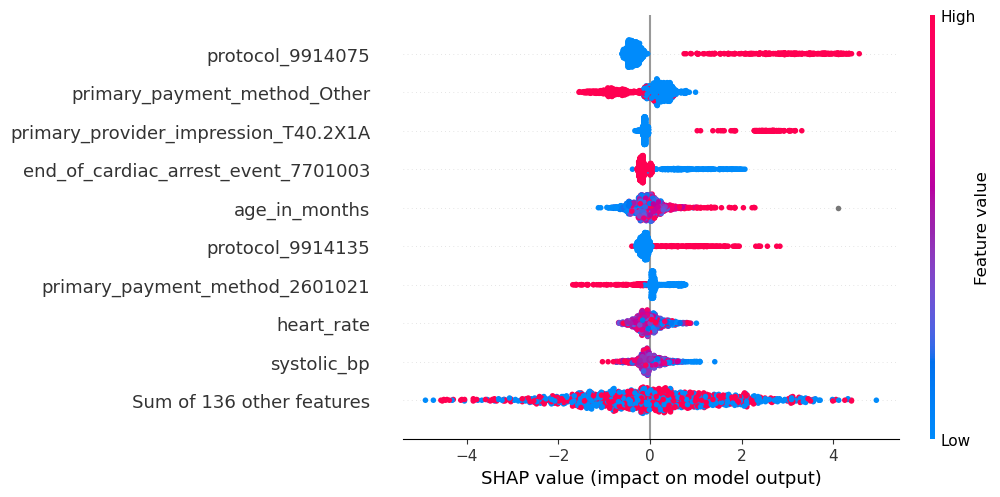

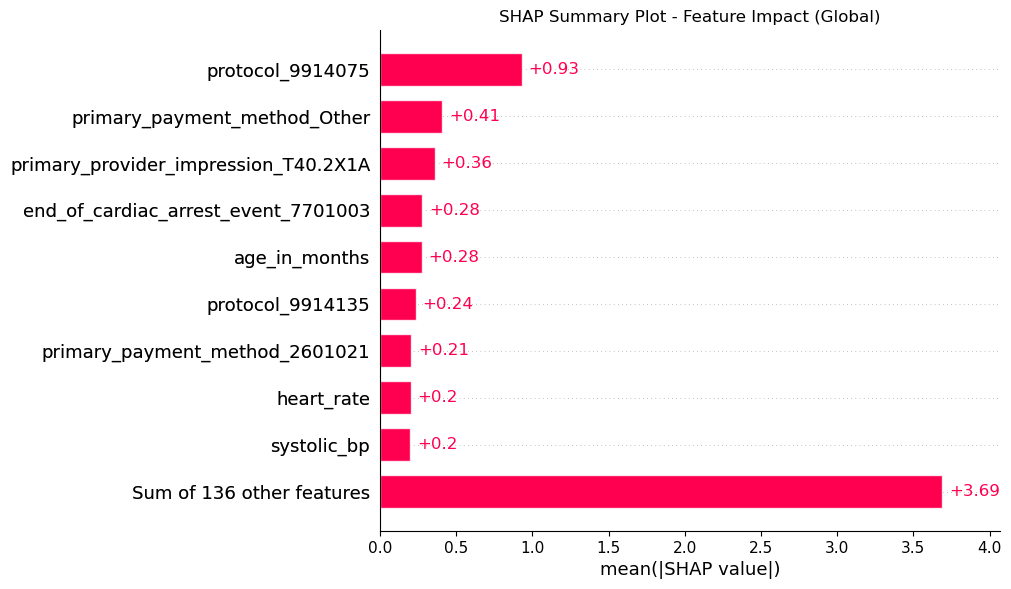

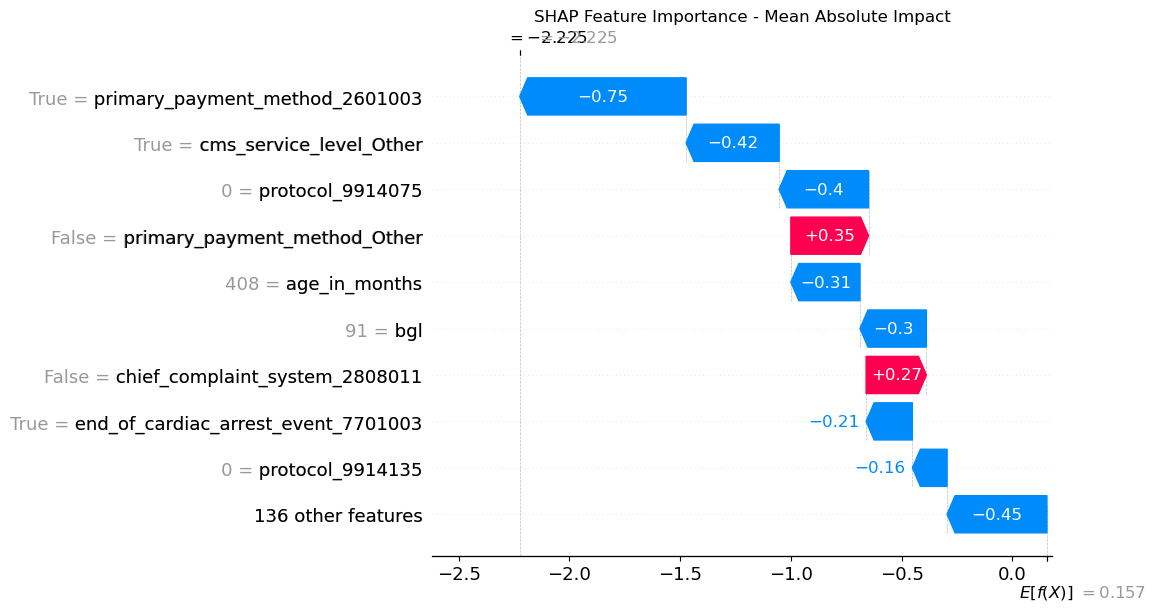

In [521]:
# Re-initialize SHAP explainer for the tuned model
explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_test)

# Global Summary Plot (Beeswarm)
shap.plots.beeswarm(shap_values)
plt.title("SHAP Summary Plot - Feature Impact (Global)")

# Global Bar Plot (Average Absolute SHAP Values)
shap.plots.bar(shap_values)
plt.title("SHAP Feature Importance - Mean Absolute Impact")

# Local Explanation for One Sample
# You can change the index (e.g., shap_values[10]) to examine other cases
shap.plots.waterfall(shap_values[0])

In [527]:
# Define admit/discharge flags from the original target
modeling_df["discharged_flag"] = 1 - modeling_df["target_admit"]

# Define no-insurance label
no_insurance_label = "2601021"

# Add binary flag for no insurance
modeling_df["no_insurance"] = (modeling_df["primary_payment_method"] == no_insurance_label).astype(int)

# Group by insurance status and compute discharge rate
discharge_rates = (
    modeling_df.groupby("no_insurance")["discharged_flag"]
    .agg(["count", "mean"])
    .rename(columns={"count": "n_patients", "mean": "discharge_rate"})
)

# Add labels for clarity
discharge_rates.index = ["Has Insurance", "No Insurance"]
print(discharge_rates)

               n_patients  discharge_rate
Has Insurance        4828        0.465617
No Insurance          849        0.465253


## Conclusion & Recommendations

This project demonstrated that supervised machine learning, specifically a tuned XGBoost classifier, can extract meaningful signal from EMS patient care reports to predict emergency department outcomes. Despite the limited dataset of 5,677 filtered opioid-related cases—representing approximately **0.01% of the ~54 million records** in the full NEMSIS dataset—the model achieved strong performance, with an ROC AUC of 0.91 and a recall of 81% for high-risk patients (those admitted, transferred, or deceased).

These results suggest there is real predictive power in EMS documentation that can be harnessed to inform education, triage policy, and targeted public health interventions. While this is not a deployable clinical tool, it underscores the **untapped potential of EMS data** in the fight against the opioid epidemic.

As of this writing, the **2024 NEMSIS Public-Release Research Dataset has been made available**, and **incorporating this new data is on the project roadmap**. Additional records will help improve model generalizability and allow deeper analysis of year-over-year trends in overdose response and outcomes.

### Recommendations

1. **Expand data availability**: This project was constrained by the limited number of records with known hospital outcomes. Expanding access to ED disposition data—either through better data sharing agreements or improved NEMSIS reporting—would drastically increase modeling power.

2. **Encourage system-level partnerships**: Medical directors, public health departments, and hospital systems should view EMS agencies as critical partners in data-driven harm reduction strategies. Broader collaboration could support predictive models for many high-risk conditions beyond overdose.

3. **Promote EMS data use in public health**: With sufficient data, EMS reports could help identify patterns in overdose severity, response effectiveness, and social determinants of health in near real time.

This project should serve as a **proof of concept** and motivator for the EMS and public health communities to invest in linking and leveraging their data. While no single tool will solve the opioid crisis, integrating predictive analytics into prehospital care could be one more way to save lives.